# How to Build Supervised Models When You Don’t Have Annotated Data
Active learning is one of the most effective ways to bootstrap supervised learning workflows when annotated datasets don’t exist yet. The key requirement is simply that your model can produce a reliable measure of confidence.

In this article, we’ll walk through how to apply this strategy step-by-step and show how active learning can help you build high-quality supervised models with minimal labeling effort.

## Installing the libraries

In [2]:
!pip install numpy pandas scikit-learn matplotlib

### Importing the dependencies
For this tutorial, we will be using the make_classification dataset from the sklearn library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

***NUM_QUERIES = 20*** represents the annotation budget in an active learning setup. In a real-world workflow, this would mean the model selects the 20 most confusing samples and sends them to human annotators to label—each annotation costing time and money. In our simulation, we replicate this process automatically: during each iteration, the model selects one uncertain sample, the code instantly retrieves its true label (acting as the human oracle), and the model is retrained with this new information. Thus, setting NUM_QUERIES = 20 means we're simulating the benefit of labeling only 20 strategically chosen samples and observing how much the model improves with that limited but valuable human effort.

In [2]:
SEED = 42 # For reproducibility
N_SAMPLES = 1000 # Total number of data points
INITIAL_LABELED_PERCENTAGE = 0.10 # Your constraint: Start with 10% labeled data
NUM_QUERIES = 20 # Number of times we ask the "human" to label a confusing sample

## Data Generation and Splitting Strategy for Active Learning
This block handles data generation and the initial split that powers the entire Active Learning experiment. It first uses make_classification to create 1,000 synthetic samples for a two-class problem. The dataset is then split into a 10% held-out test set for final evaluation and a 90% pool for training. From this pool, only 10% is kept as the small initial labeled set—matching the constraint of starting with very limited annotations—while the remaining 90% becomes the unlabeled pool. This setup creates the realistic low-label scenario Active Learning is designed for, with a large pool of unlabeled samples ready for strategic querying.

In [4]:
X, y = make_classification(
    n_samples=N_SAMPLES, n_features=10, n_informative=5, n_redundant=0,
    n_classes=2, n_clusters_per_class=1, flip_y=0.1, random_state=SEED
)

# 1. Split into 90% Pool (samples to be queried) and 10% Test (final evaluation)
X_pool, X_test, y_pool, y_test = train_test_split(
    X, y, test_size=0.10, random_state=SEED, stratify=y
)

# 2. Split the 90% Pool into Initial Labeled (10% of the pool) and Unlabeled (90% of the pool)
X_labeled_current, X_unlabeled_full, y_labeled_current, y_unlabeled_full = train_test_split(
    X_pool, y_pool, test_size=1.0 - INITIAL_LABELED_PERCENTAGE,
    random_state=SEED, stratify=y_pool
)

# A set to track indices in the unlabeled pool for efficient querying and removal
unlabeled_indices_set = set(range(X_unlabeled_full.shape[0]))

print(f"Initial Labeled Samples (STARTING N): {len(y_labeled_current)}")
print(f"Unlabeled Pool Samples: {len(unlabeled_indices_set)}")

Initial Labeled Samples (STARTING N): 90
Unlabeled Pool Samples: 810


## Initial Training and Baseline Evaluation
This block trains the initial Logistic Regression model using only the small labeled seed set and evaluates its accuracy on the held-out test set. The labeled sample count and baseline accuracy are then stored as the first points in the performance history, establishing a starting benchmark before Active Learning begins.

In [5]:
labeled_size_history = []
accuracy_history = []

# Train the baseline model on the small initial labeled set
baseline_model = LogisticRegression(random_state=SEED, max_iter=2000)
baseline_model.fit(X_labeled_current, y_labeled_current)

# Evaluate performance on the held-out test set
y_pred_init = baseline_model.predict(X_test)
accuracy_init = accuracy_score(y_test, y_pred_init)

# Record the baseline point (x=90, y=0.8800)
labeled_size_history.append(len(y_labeled_current))
accuracy_history.append(accuracy_init)

print(f"INITIAL BASELINE (N={labeled_size_history[0]}): Test Accuracy: {accuracy_history[0]:.4f}")

INITIAL BASELINE (N=90): Test Accuracy: 0.8800


## Active Learning Loop
This block contains the heart of the Active Learning process, where the model iteratively selects the most uncertain sample, receives its true label, retrains, and evaluates performance. In each iteration, the current model predicts probabilities for all unlabeled samples, identifies the one with the highest uncertainty (least confidence), and “queries” its true label—simulating a human annotator. The newly labeled data point is added to the training set, a fresh model is retrained, and accuracy is recorded. Repeating this cycle for 20 queries demonstrates how targeted labeling quickly improves model performance with minimal annotation effort.

In [6]:
current_model = baseline_model # Start the loop with the baseline model

print(f"\nStarting Active Learning Loop ({NUM_QUERIES} Queries)...")

# -----------------------------------------------
# The Active Learning Loop (Query, Annotate, Retrain, Evaluate)
# Purpose: Run 20 iterations to demonstrate strategic labeling gains.
# -----------------------------------------------
for i in range(NUM_QUERIES):
    if not unlabeled_indices_set:
        print("Unlabeled pool is empty. Stopping.")
        break

    # --- A. QUERY STRATEGY: Find the Least Confident Sample ---
    # 1. Get probability predictions from the CURRENT model for all unlabeled samples
    probabilities = current_model.predict_proba(X_unlabeled_full)
    max_probabilities = np.max(probabilities, axis=1)

    # 2. Calculate Uncertainty Score (1 - Max Confidence)
    uncertainty_scores = 1 - max_probabilities

    # 3. Identify the index of the sample with the MAXIMUM uncertainty score
    current_indices_list = list(unlabeled_indices_set)
    current_uncertainty = uncertainty_scores[current_indices_list]
    most_uncertain_idx_in_subset = np.argmax(current_uncertainty)
    query_index_full = current_indices_list[most_uncertain_idx_in_subset]
    query_uncertainty_score = uncertainty_scores[query_index_full]

    # --- B. HUMAN ANNOTATION SIMULATION ---
    # This is the single critical step where the human annotator intervenes.
    # We look up the true label (y_unlabeled_full) for the sample the model asked for.
    X_query = X_unlabeled_full[query_index_full].reshape(1, -1)
    y_query = np.array([y_unlabeled_full[query_index_full]])

    # Update the Labeled Set: Add the new annotated sample (N becomes N+1)
    X_labeled_current = np.vstack([X_labeled_current, X_query])
    y_labeled_current = np.hstack([y_labeled_current, y_query])
    # Remove the sample from the unlabeled pool
    unlabeled_indices_set.remove(query_index_full)

    # --- C. RETRAIN and EVALUATE ---
    # Train the NEW model on the larger, improved labeled set
    current_model = LogisticRegression(random_state=SEED, max_iter=2000)
    current_model.fit(X_labeled_current, y_labeled_current)

    # Evaluate the new model on the held-out test set
    y_pred = current_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Record results for plotting
    labeled_size_history.append(len(y_labeled_current))
    accuracy_history.append(accuracy)

    # Output status
    print(f"\nQUERY {i+1}: Labeled Samples: {len(y_labeled_current)}")
    print(f"  > Test Accuracy: {accuracy:.4f}")
    print(f"  > Uncertainty Score: {query_uncertainty_score:.4f}")

final_accuracy = accuracy_history[-1]


Starting Active Learning Loop (20 Queries)...

QUERY 1: Labeled Samples: 91
  > Test Accuracy: 0.8700
  > Uncertainty Score: 0.4993

QUERY 2: Labeled Samples: 92
  > Test Accuracy: 0.8900
  > Uncertainty Score: 0.4866

QUERY 3: Labeled Samples: 93
  > Test Accuracy: 0.8900
  > Uncertainty Score: 0.4957

QUERY 4: Labeled Samples: 94
  > Test Accuracy: 0.8900
  > Uncertainty Score: 0.4999

QUERY 5: Labeled Samples: 95
  > Test Accuracy: 0.9000
  > Uncertainty Score: 0.4981

QUERY 6: Labeled Samples: 96
  > Test Accuracy: 0.8900
  > Uncertainty Score: 0.4971

QUERY 7: Labeled Samples: 97
  > Test Accuracy: 0.9000
  > Uncertainty Score: 0.4936

QUERY 8: Labeled Samples: 98
  > Test Accuracy: 0.9000
  > Uncertainty Score: 0.4991

QUERY 9: Labeled Samples: 99
  > Test Accuracy: 0.9000
  > Uncertainty Score: 0.4957

QUERY 10: Labeled Samples: 100
  > Test Accuracy: 0.9000
  > Uncertainty Score: 0.4981

QUERY 11: Labeled Samples: 101
  > Test Accuracy: 0.9000
  > Uncertainty Score: 0.4856

QU

## Final Result
The experiment successfully validated the efficiency of Active Learning. By focusing annotation efforts on only **20** strategically selected samples (increasing the labeled set from 90 to 110), the model's performance on the unseen Test Set improved from **0.8800 (88%)** to **0.9100 (91%)**. This 3 percentage point increase in accuracy was achieved with a minimal increase in annotation effort—roughly a 22% increase in the size of the training data resulted in a measurable and meaningful performance boost. In essence, the Active Learner acts as an intelligent curator, ensuring that every dollar or minute spent on human labeling provides the maximum possible benefit, proving that smart labeling is far more valuable than random or bulk labeling.

In [7]:
print("\n--- FINAL SUMMARY ---")
print(f"Initial Accuracy (with {labeled_size_history[0]} samples): {accuracy_history[0]:.4f}")
print(f"Final Accuracy (with {labeled_size_history[-1]} samples): {final_accuracy:.4f}")
print(f"Total strategic samples labeled: {NUM_QUERIES}")


--- FINAL SUMMARY ---
Initial Accuracy (with 90 samples): 0.8800
Final Accuracy (with 110 samples): 0.9100
Total strategic samples labeled: 20


## Plotting the results

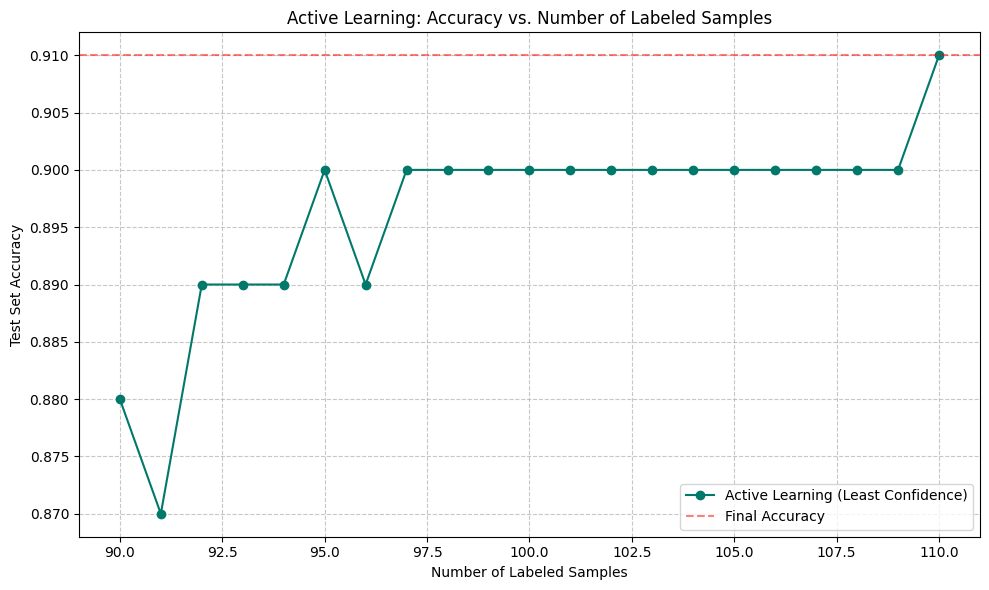

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(labeled_size_history, accuracy_history, marker='o', linestyle='-', color='#00796b', label='Active Learning (Least Confidence)')
plt.axhline(y=final_accuracy, color='red', linestyle='--', alpha=0.5, label='Final Accuracy')
plt.title('Active Learning: Accuracy vs. Number of Labeled Samples')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Set Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()